<a href="https://colab.research.google.com/github/AliAkbarBadri/mountain-car-v0/blob/master/MountainCar_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
import matplotlib.animation
from IPython.display import HTML
from IPython.display import display as ipy_disp
import tensorflow as tf
import keras
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gym
import random

In [3]:
def get_screen():
  global display
  try:
    display.stop()
  except:
    pass
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()

get_screen()

In [4]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [5]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [6]:
import numpy as np
import gym
import collections
import random
import cv2
import keras
from keras.models import Model
from keras import layers
from keras import backend as K
from keras import optimizers
import pickle


#Set channel format for inputs
keras.backend.set_image_data_format('channels_first')


class CarAgent:
    def __init__(self, env):
        self.env = env
        self.num_actions = 3
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.decay_factor = (self.epsilon - self.epsilon_min) / 25000
        self.discount_factor = 0.99                   
        self.memory = collections.deque(maxlen=200000) 
        self.learning_rate = 0.001                  
        self.image_width = 150                         
        self.image_height = 100                       
        self.stack_depth = 4                           
        self.model = self.create_CNN_model()           
        self.target_model = self.create_CNN_model()    
        self.update_target_weights()                   
                                                         


    def create_CNN_model(self):

        input_shape = (self.stack_depth, self.image_height, self.image_width)
        actions_input = layers.Input((self.num_actions,), name = 'action_mask')

        frames_input = layers.Input(input_shape, name='input_layer')
        conv_1 = layers.Conv2D(32, (8,8), strides=4, padding ='same'\
        ,activation = 'relu', name='conv_1',kernel_initializer='glorot_uniform',bias_initializer='zeros')(frames_input)

        conv_2 = layers.Conv2D(64, (4,4), strides=2, padding='same', activation='relu',name='conv_2'\
           ,kernel_initializer='glorot_uniform',bias_initializer='zeros')(conv_1)

        conv_3 = layers.Conv2D(64, (3,3), strides=1, padding='same',name='conv_3', activation='relu'\
           ,kernel_initializer='glorot_uniform',bias_initializer='zeros')(conv_2)

        flatten_1 = layers.Flatten()(conv_3)

        dense_1 = layers.Dense(512, activation='relu', name='dense_1',
            kernel_initializer='glorot_uniform',bias_initializer='zeros')(flatten_1)
        output = layers.Dense(self.num_actions, activation='linear', name='output',
            kernel_initializer='glorot_uniform',bias_initializer='zeros')(dense_1)
        masked_output = layers.Multiply(name='masked_output')([output, actions_input])

        model = Model([frames_input, actions_input], [masked_output])
        optimizer = optimizers.Adam(lr = self.learning_rate)
        model.compile(optimizer,loss=keras.losses.huber)
        return model

    def update_target_weights(self):
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])

    def process_image(self, image):
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        image = cv2.resize(image, (self.image_width, self.image_height))

        return image

    def greedy_action(self, current_state):
        current_state = np.float32(np.true_divide(current_state,255))
        action_mask = np.ones((1, self.num_actions))
        q_values = self.model.predict([current_state, action_mask])[0]
        greedy_action = np.argmax(q_values)

        return greedy_action

    def calculate_targets(self, batch_size):
        current_states = []
        rewards = []
        actions = []
        next_states = []
        dones = []
        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, next_state, done = sample
            current_states.append(state)
            rewards.append(reward)
            actions.append(action)
            next_states.append(next_state)
            dones.append(done)

        current_states = np.array(current_states)
        current_states = np.float32(np.true_divide(current_states,255))
        next_states = np.array(next_states)
        next_states = np.float32(np.true_divide(next_states,255))
        action_mask = np.ones((1,self.num_actions))
        action_mask = np.repeat(action_mask, batch_size, axis=0)
        next_Q_values = self.target_model.predict([next_states, action_mask])
        next_Q_values[dones] = 0
        targets = rewards + self.discount_factor * np.max(next_Q_values, axis=1)
        action_mask_current = self.get_one_hot(actions)

        return current_states, action_mask_current, targets

    def get_one_hot(self,actions):
        actions = np.array(actions)
        one_hots = np.zeros((len(actions), self.num_actions))

        one_hots[:, 0][np.where(actions == 0)] = 1
        one_hots[:,1][np.where(actions == 1)] = 1
        one_hots[:, 2][np.where(actions == 2)] = 1

        return one_hots

    def train_from_experience(self, states, action_mask, targets ):
        labels = action_mask * targets[:, None]
        loss = self.model.train_on_batch([states, action_mask], labels)

    def save_model(self,name):
        self.model.save(name)

env = gym.make('MountainCar-v0')
agent = CarAgent(env)
stack_depth = 4
seq_memory = collections.deque(maxlen=stack_depth)
done = False
training = False
batch_size = 32
update_threshold = 5
save_threshold = 200
episodes = 601
time_steps = 200
collect_experience = 5000#agent.memory.maxlen - 50000
frame_skip = 4
ep_reward = []

for episode in range(1,episodes):
    seq_memory.clear()
    initial_state = env.reset()
    current_image = env.render(mode = 'rgb_array')
    frame = agent.process_image(current_image)
    frame = frame.reshape(1, frame.shape[0], frame.shape[1])
    current_state = np.repeat(frame, stack_depth, axis=0)
    seq_memory.extend(current_state)
    episode_reward = 0
    for time in range(time_steps):
        if time % frame_skip == 0:
            if training:
                agent.epsilon = agent.epsilon - agent.decay_factor
                agent.epsilon = max(agent.epsilon_min, agent.epsilon)
            if np.random.rand() <= agent.epsilon:
                action = env.action_space.sample()
            else:
                action = agent.greedy_action(current_state.reshape(1, current_state.shape[0]\
                                   , current_state.shape[1], current_state.shape[2]))
        next_pos, reward, done, _ = env.step(action)
        next_frame = env.render(mode='rgb_array')
        next_frame = agent.process_image(next_frame)
        seq_memory.append(next_frame)
        next_state = np.asarray(seq_memory)
        agent.memory.append([current_state, action, reward, next_state, done])
        current_state = next_state
        if len(agent.memory) == collect_experience:
            training = True
            print('Start training')
        if training:
            states, action_mask, targets = agent.calculate_targets(batch_size)
            agent.train_from_experience(states,action_mask, targets)
        episode_reward = episode_reward + reward
        if done:
            break
    ep_reward.append([episode, episode_reward])
    # if episode % 100 == 0:
    print("episode: {}, epsilon: {}, episode reward: {}".format(episode, agent.epsilon, episode_reward))
    if training and (episode % update_threshold) == 0:
        # print('Weights updated at epsisode:', episode)
        agent.update_target_weights()
    if training and (episode%save_threshold) == 0:
        print('Data saved at epsisode:', episode)
        agent.save_model('./DQN_CNN_model_{}.h5'.format(episode))
        pickle.dump(ep_reward, open('./rewards_{}.dump'.format(episode), 'wb'))

env.close()

episode: 1, epsilon: 1.0, episode reward: -200.0
episode: 2, epsilon: 1.0, episode reward: -200.0
episode: 3, epsilon: 1.0, episode reward: -200.0
episode: 4, epsilon: 1.0, episode reward: -200.0
episode: 5, epsilon: 1.0, episode reward: -200.0
episode: 6, epsilon: 1.0, episode reward: -200.0
episode: 7, epsilon: 1.0, episode reward: -200.0
episode: 8, epsilon: 1.0, episode reward: -200.0
episode: 9, epsilon: 1.0, episode reward: -200.0
episode: 10, epsilon: 1.0, episode reward: -200.0
episode: 11, epsilon: 1.0, episode reward: -200.0
episode: 12, epsilon: 1.0, episode reward: -200.0
episode: 13, epsilon: 1.0, episode reward: -200.0
episode: 14, epsilon: 1.0, episode reward: -200.0
episode: 15, epsilon: 1.0, episode reward: -200.0
episode: 16, epsilon: 1.0, episode reward: -200.0
episode: 17, epsilon: 1.0, episode reward: -200.0
episode: 18, epsilon: 1.0, episode reward: -200.0
episode: 19, epsilon: 1.0, episode reward: -200.0
episode: 20, epsilon: 1.0, episode reward: -200.0
episode: 

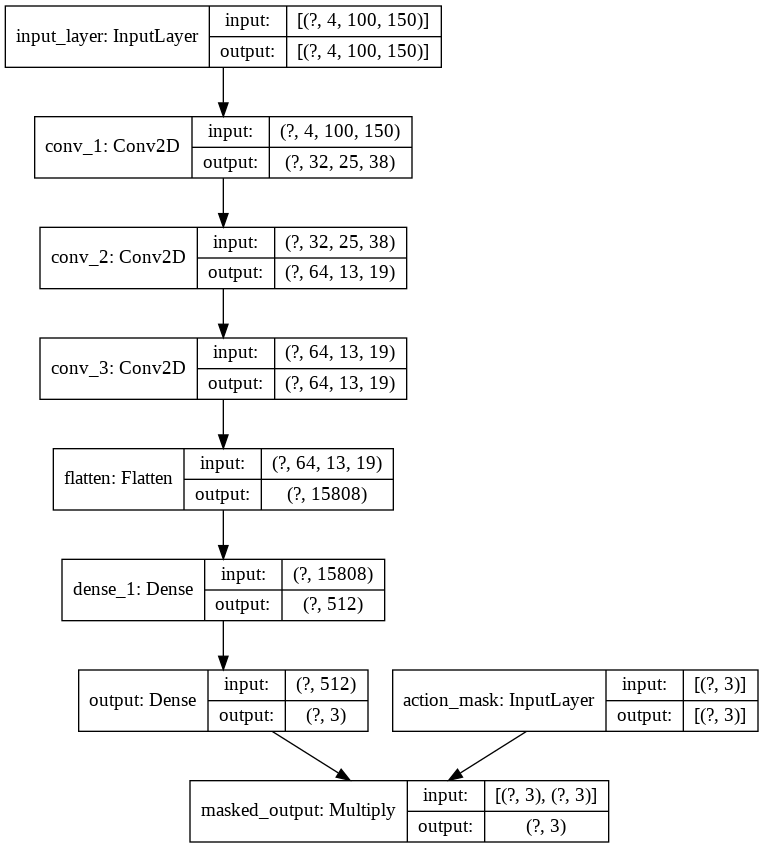

In [7]:
keras.utils.plot_model(agent.model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
ep_reward

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(ep_reward[:,1])
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

TypeError: ignored

<Figure size 576x288 with 0 Axes>

# **Test**

In [ ]:
env = gym.make("MountainCar-v0")
import keras

loaded_model = keras.models.load_model('original_cnn.h5')

trials = 10
trial_len = 200
all_rewards_test = []
for trial in range(trials):
    cur_state = env.reset().reshape(1, 2)
    for step in range(trial_len):
        action = np.argmax(loaded_model.predict(cur_state)[0])
        cur_state, reward, done, _ = env.step(action)
        cur_state = cur_state.reshape(1, 2)
        if done:
            env.reset()
            break
    all_rewards_test.append(step+1)
    print("Iteration: {} Score: -{}".format(trial, step+1))

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(all_rewards_test)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [ ]:
print("mean reward: ",np.mean(all_rewards_test),", best reward:",np.min(all_rewards_test),", first win episode:",np.argmin(all_rewards_test))